# Pytorch Geometric

La paquetería de pytorch geometric está pensada para elaborar capas de redes gráficas. Esta paquetería ya contiene algunas capas pre-definidas, pero también nos permite elaborar nuestras propias capas para integrarlas en un modelo de red neuronal de gráfica. Pytorch geometric se suele utilizar junto con torch, pues dependen uno del otro.

Importamos entonces torch, torch.nn, torch_geometric y torch_geometric.nn además de otras paqueterías auxiliares.

In [1]:
import torch
import torch.nn as nn
import torch_geometric as geo_torch
import torch_geometric.nn as geo_nn
import numpy as np
import networkx as nx

## Creación de datos

En primer lugar, definiremos nuestros datos. En este caso, podemos usar tensores en formato torch. Declararemos unos datos de entrada, unas clases de salida y una matriz de adyacencia.

In [2]:
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
y = torch.tensor([0, 1, 0], dtype=torch.long)
A = torch.tensor([[0, 1, 0],[1, 0, 1],[0, 1, 0]])

Pytorch geometric trabaj con un formato particular para indicar las aristas de la gráfica. Este formato está basado en dos renglones donde cada columna presenta una adyacencia. Por ejemplo, si tenemos una adyacencia $(n_i,n_j) \in E$, entonces crearemos la columna:

$$\begin{bmatrix} n_i \\ n_j \end{bmatrix}$$

En el caso anterior, por ejemplo, tendríamos el siguiente ínidice de aristas:

$$\begin{bmatrix} n_0 & n_1 & n_1 & n_2 \\ n_1 & n_0 & n_2 & n_1 \end{bmatrix}$$

In [3]:
edge_index = A.nonzero().t().contiguous() 
print(edge_index)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


Para generar los datos, se puede utilizar la función de torch_geometric.data.Data, la cual guardará los datos, las clases, y la información de adyacencia.

In [4]:
data = geo_torch.data.Data(x=x, y=y, edge_index=edge_index)
data.x

tensor([[-1.],
        [ 0.],
        [ 1.]])

También podemos obtener una gráfica en formato networkx a partir de la función to_networkx:

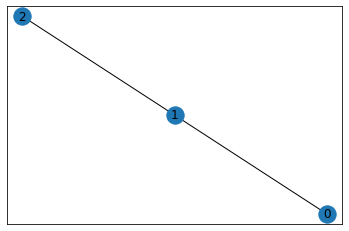

In [5]:
G = geo_torch.utils.to_networkx(data, to_undirected=True)
nx.draw_networkx(G, with_labels=True)

## Creación de capas

Para crear capas de redes de gráficas, pytroch geometric nos permite definir el procesamiento de estas capas de manera sencilla. Para esto se ocupa <b>torch_geometric.nn.MessagePassing</b>, crearemos entonces una capa de tipo Message Passing que necesita especificar lo siguiente: 

* La función de agregación, esto se hace después del __init__ de la siguiente forma:
```python
  super().__init__(aggr='Método_de_agregación')
``` 
Se pueden tomar diferentes métodos de agregación: 1) 'add' - suma; 2) 'mean' - meadia; y 3) 'max' - máximo
* Indicar las capas que se van a usar, ya sean de pytorch o pytorch_geometric.
* En el forward se indicará el preprocesamiento de los datos y se obtendrá la salida. En el forward mandaremos llamar la función de message por medio de:
```python
    self.propagate(x=x, edge_index=edge_index)
```
propagate refiere a la función de la capa $F(x, X_{\mathcal{N}_x})$, que propaga el mensaje en base a la adyacencia de la gráfica. Se puede agregar un factor de normalización norm=norm si la función de difusión recibe algún tipo de normalización.
* La función message se encarga de propagar el mensaje, en este caso, debemos indicar la función de difusión. El mesanje se propagará según la función de agregación que hemos indicado con anterioridad.

En la capa de abajo indicamos que queremos agregación de suma en __init__, forward aplicamos una transformación lineal a los datos y calculamos una normalización $norm = \frac{1}{deg(x_i) deg(x_j)}$, entonces enviamos $x$ y la normalización para que se propaguen. La propagación final, considerando la agregación y demás será de la forma:

$$h_i = \sum_{j \in \mathcal{N}_i} \frac{1}{deg(i)deg(j)} \psi(x_j) + b$$

donde $\psi(x)$ es una capa lineal.

In [6]:
class GCNConv(geo_nn.MessagePassing):
    def __init__(self, in_channels=1, out_channels=2):
        super().__init__(aggr='add') #La agregación será por suma
        #Capa lineal
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        """Reinicia los parámetros de la red"""
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        #Añade lazos a la adyacencia para que un nodo sea vecino siempre de sí mismo
        edge_index, _ = geo_torch.utils.add_self_loops(edge_index, num_nodes=x.size(0))

        #Transformación lineal sobre x
        x = self.lin(x)

        #Computar normalización, raíz cuadrada de grados
        row, col = edge_index
        deg = geo_torch.utils.degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        #Hacer la difusión de los mensajes
        #propagate hace referencia a la función message de abajo
        out = self.propagate(edge_index, x=x, norm=norm)

        #Aplicar el vector del bias después de la difusión
        out += self.bias

        return out

    def message(self, x_j, norm):
        """Determina la difusión del mensaje"""
        #Propagación del mensaje por método aggr
        return norm.view(-1, 1) * x_j

Una vez definida nuestra capa gráfica, podemos definir nuestro modelo de red neuronal, ya sea por medio de un Módulo o usando el método $torch_geometric.nn.Sequential$, que funciona de forma similar a Sequential en torch, pero indicamos los valores que entran (x, y la adyacencia) y como trabajan las capas gráficas.

In [7]:
#Creación del modelo con Sequential
model = geo_nn.Sequential('x, edge_index', [(GCNConv(data.num_node_features, 64), 'x,edge_index->x'),
                                           nn.ReLU(inplace=True), nn.Linear(64, 2), nn.Softmax(1)])

Entrenamos nuestro modelo de forma similar que en torch, sólo notamos que el modelo toma como inputs al vector de entrada y a su adyacencia.

In [8]:
risk = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = risk(out, data.y)
    loss.backward()
    optimizer.step()

Podemos entonces ya usar nuestra red de gráfica con los pesos óptimos.

In [9]:
model.eval()
model(data.x, data.edge_index).argmax(axis=1)

tensor([0, 1, 0])

## Ejemplo: Sparse AutoEncoder con redes gráficas

Para hacer un ejemplo más complejo, podemos definir una especie de sparse autoencoder. En este caso tomaremos imagenes que tengan un sólo canal, y los codificaremos a imagenes con 3 canales. Tomamos el dataset MNIST donde los digitos cuentan con sólo un canal.

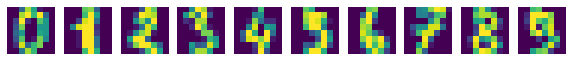

In [10]:
from sklearn.datasets import load_digits
from tqdm import tqdm
import matplotlib.pyplot as plt

data = np.array([x_i.reshape(8,8) for x_i in load_digits().data])

def plot_images(images, num=4):
    """Visualización de imagenes"""
    _, axes = plt.subplots(nrows=1, ncols=num, figsize=(10, 3))
    for ax, image in zip(axes, images):
        ax.set_axis_off()
        ax.imshow(image)
        
plot_images(data, num=10)

Definimos los ejemplos. En este caso, tendremos que codificar los datos en imágenes de 3 canales, después decodificarlo para obtener una reconstrucción de la imagen original. La imagen deseada estará entonces en el medio de la red. La entrada y la salida serán los mismos, definiremos una adyacencia basada en la estructura de grid.

In [11]:
#Entrada
x = torch.Tensor([x_i.reshape(64,1) for x_i in data])
#Salida
y = torch.Tensor([x_i.reshape(64) for x_i in data])
#Adyacencia grid
edge_index,_ = geo_torch.utils.grid(8, 8, dtype=torch.long)

Usaremos las capas de pytorch_geometric que ya vienen pre-definidas. Algunas de estas capas pueden encontrarse en: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html
Definiremos un encoder que tomará las imagenes con 1 canal y las llevará hacia 3 canales. El decoder tomará estos 3 canales y buscará reconstruir las imágenes originales.

In [12]:
#encoder = geo_nn.Sequential('x, edge_index', [(geo_nn.GCNConv(1, 2), 'x,edge_index->x'),nn.ReLU(),
#                                              (geo_nn.GCNConv(2, 3), 'x,edge_index->x'), nn.Sigmoid()])
#decoder = geo_nn.Sequential('x, edge_index', [(geo_nn.GCNConv(3, 2), 'x,edge_index->x'), nn.ReLU(),
#                                              (geo_nn.GCNConv(2, 1), 'x,edge_index->x'), nn.ReLU()])

#encoder = geo_nn.Sequential('x, edge_index', [(geo_nn.FeaStConv(1, 2), 'x,edge_index->x'),nn.ReLU(),
#                                              (geo_nn.FeaStConv(2, 3), 'x,edge_index->x'), nn.Sigmoid()])
#decoder = geo_nn.Sequential('x, edge_index', [(geo_nn.FeaStConv(3, 2), 'x,edge_index->x'), nn.ReLU(),
#                                              (geo_nn.FeaStConv(2, 1), 'x,edge_index->x'), nn.ReLU()])

encoder = geo_nn.Sequential('x, edge_index', [(geo_nn.ARMAConv(1, 3), 'x,edge_index->x'), nn.Sigmoid()])
decoder = geo_nn.Sequential('x, edge_index', [(geo_nn.FeaStConv(3, 1), 'x,edge_index->x'), nn.ReLU()])

encoder.load_state_dict(torch.load('MNISTArma.model'))

<All keys matched successfully>

Nuestro error será el error cuadrático medio, pues buscaremos que la imagen reconstruida sea lo más similar a la imagen de entrada:

$$R(\theta) = \frac{1}{2}\sum_x||x-\hat{x}||^2$$

Donde $\hat{x}$ es la salida del decoder. 

In [123]:
risk = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=0.01, weight_decay=5e-4)

for epoch in tqdm(range(100)):
    for x_i,y_i in zip(x,y):
        h = encoder(x_i, edge_index)
        out = decoder(h, edge_index)
        optimizer.zero_grad()
        y_i = y_i.reshape(64)
        loss = risk(out, y_i)
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [06:27<00:00,  3.88s/it]


In [124]:
torch.save(encoder.state_dict(), 'MNISTArma100.model')

Podemos entonces ver cuál es el resultado.

In [13]:
def encode(x_i):
    edge_index,_ = geo_torch.utils.grid(8, 8, dtype=torch.long)
    h = encoder(x_i, edge_index).detach().numpy()
    h = h.reshape(8,8,3)
    return h

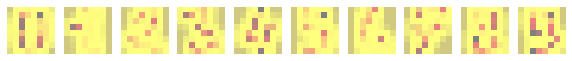

In [14]:
result = [encode(x_i) for x_i in x[:10]]
plot_images(result, num=10)